In [1]:
import re
from pathlib import Path
from typing import Iterable, Tuple

import numpy as np

from paraphone.tasks.filters.ngrams import NgramScoresCSV
from paraphone.tasks.filters.base import CandidatesPairCSV
ngram_scores_csv = NgramScoresCSV(Path("../workspaces/large_fr/candidates_filtering/ngram/scores.csv"))
candidates_csv = CandidatesPairCSV(Path("../workspaces/large_fr/candidates_filtering/steps/step_5_levenshtein.csv"))

In [2]:
all_scores = {
    phonetic: (unigram_bounded, bigram_bounded)
    for phonetic, _, unigram_bounded, _, bigram_bounded
    in ngram_scores_csv
}

In [3]:
pairs = [(word_pho, non_word_pho) for _, word_pho, non_word_pho in candidates_csv]

In [33]:
def ngram_probs_histogram(words_probs, non_word_probs, axis):
    axis.hist(np.ma.masked_invalid(words_probs),
                          color="blue",
                          alpha=0.5,
                          bins=bins,
                          label="Words")
    axis.hist(np.ma.masked_invalid(non_word_probs),
                         color="red",
                         alpha=0.5,
                         bins=bins,
                         label="Non words")
    axis.legend(loc='upper left')
    axis.set_ylabel("Count")

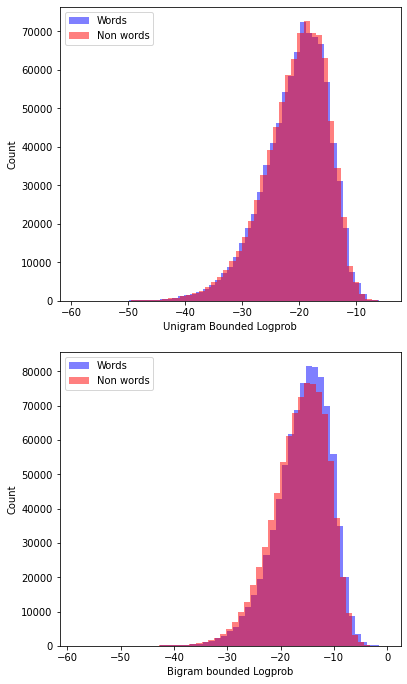

In [4]:
import matplotlib.pyplot as plt
bins = 50
fig, axs = plt.subplots(2, 1)
fig.set_figheight(10)
fig.tight_layout(pad=3.0)


for i, (ngram_type, ax) in enumerate(zip(["Unigram Bounded", "Bigram bounded"], axs)):
    words = [all_scores[pho][i] for pho, _ in pairs]
    nonwords = [all_scores[pho][i] for _, pho in pairs]
    ngram_probs_histogram(words, nonwords, ax)
    ax.set_xlabel(f"{ngram_type} Logprob")

fig.savefig("ngram_probs_histogram.png")

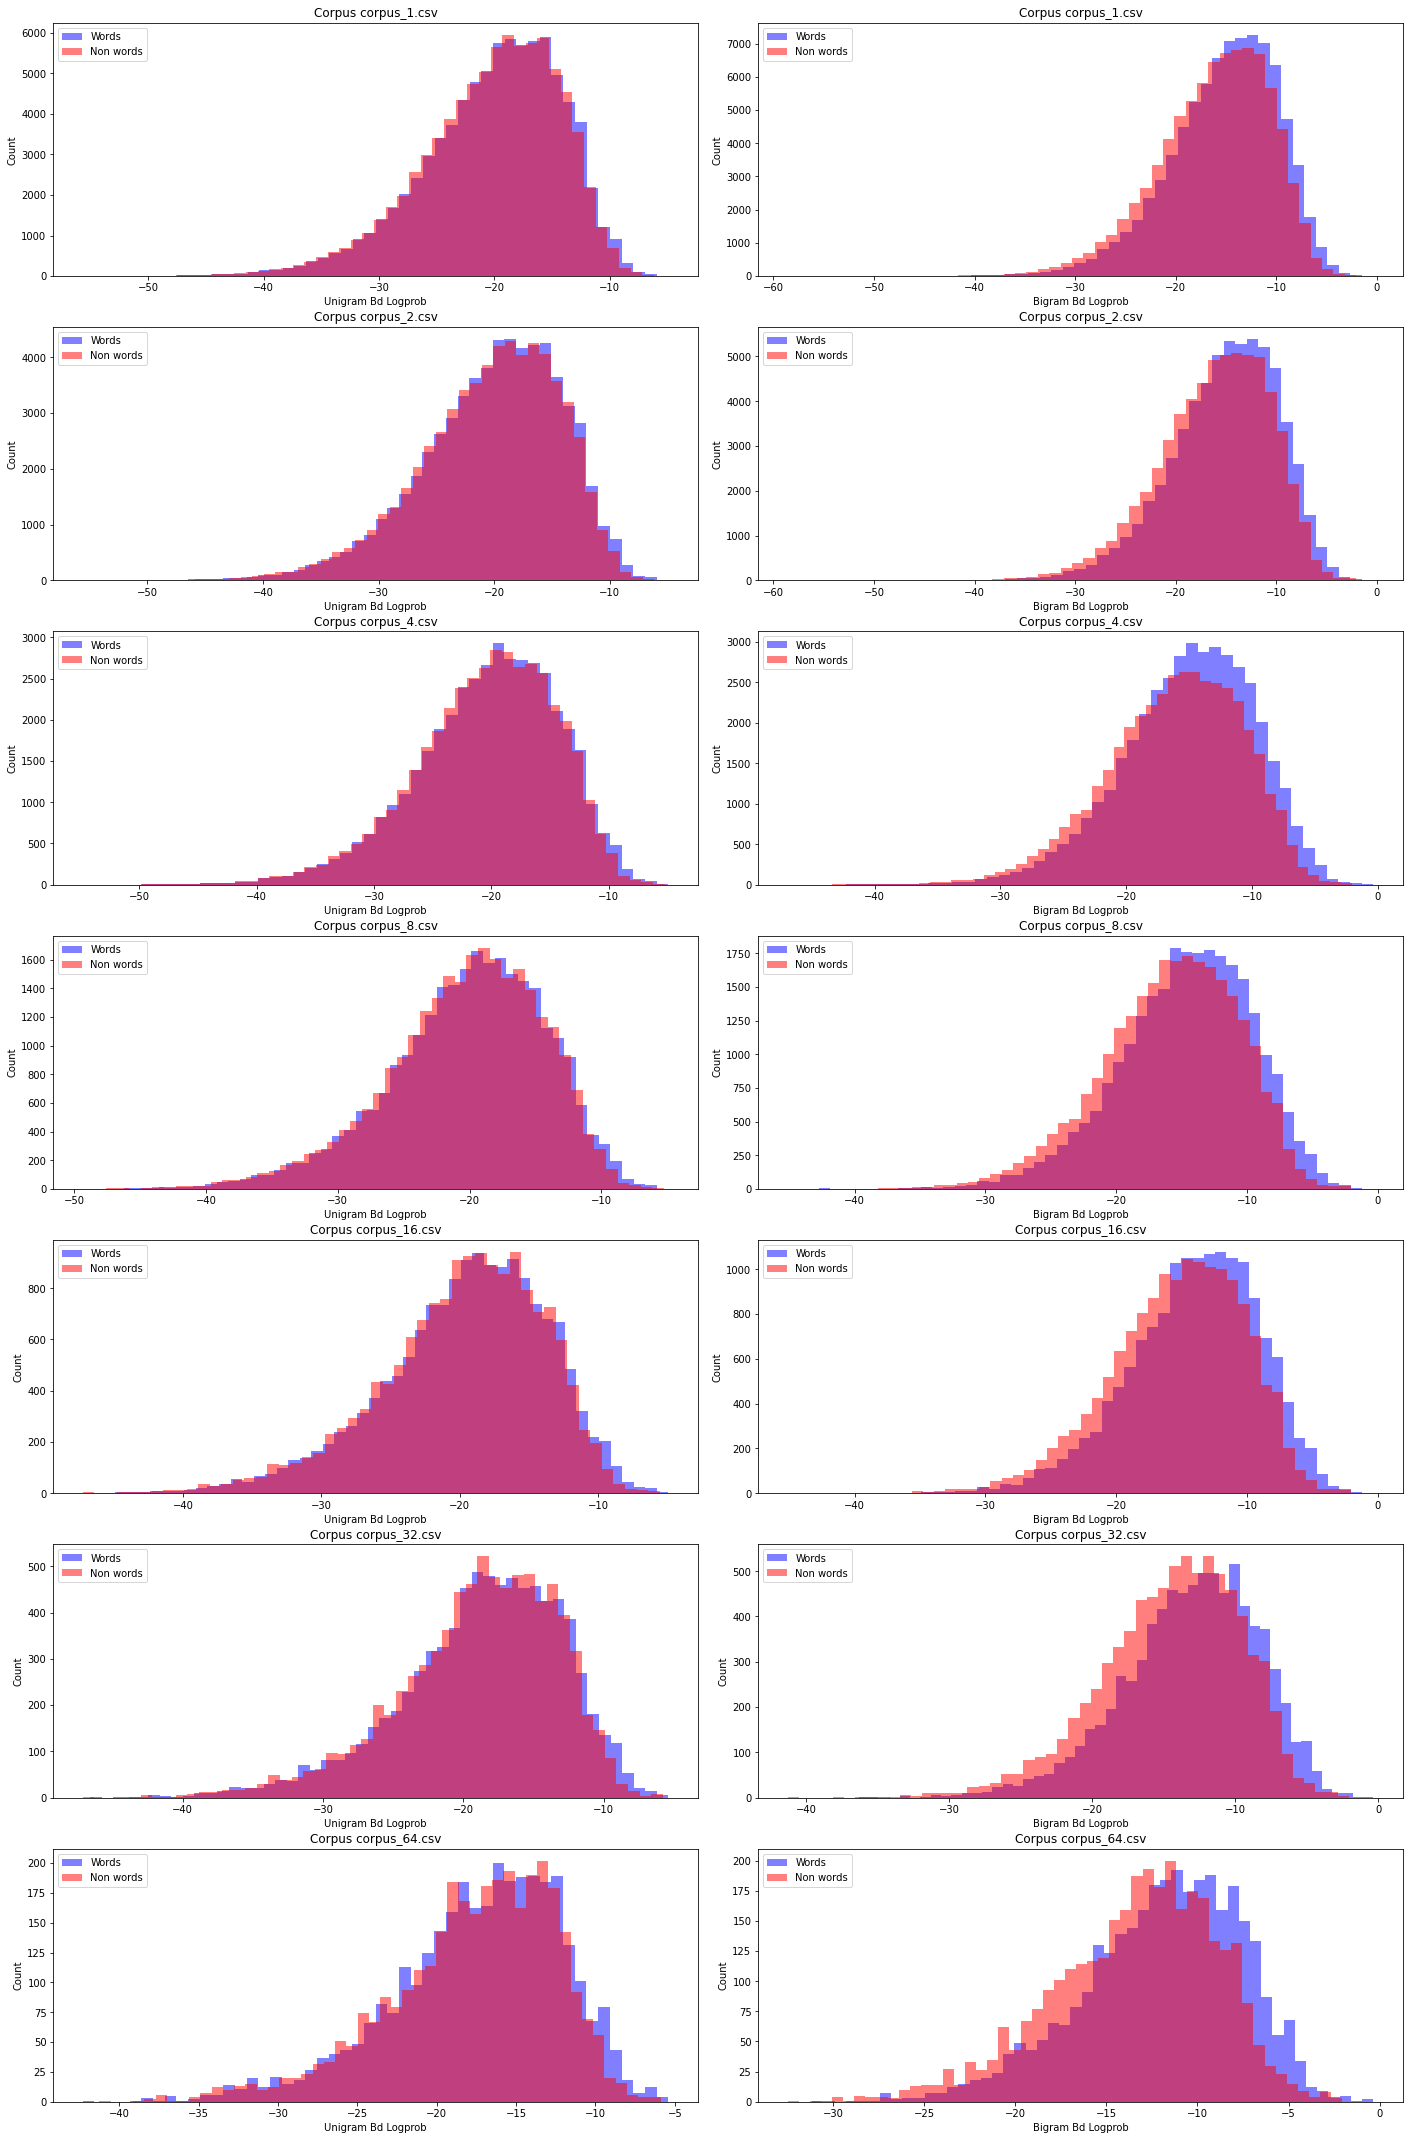

In [40]:
# Ngram prob histograms per corpus:
corpus_name_re = re.compile(r"corpus_([0-9]+)")


def iter_corpora(folder: Path) -> Iterable[Tuple[int, Path]]:
    for filepath in folder.iterdir():
        re_match = corpus_name_re.match(filepath.name)
        if re_match is not None:
            yield int(re_match[1]), filepath

CORPORA_PAIRS_FOLDER = Path("../workspaces/large_fr/corpora/wuggy_pairs/")
corpora = sorted(list(iter_corpora(CORPORA_PAIRS_FOLDER)), key=lambda x:x[0])
corpus_wuggy_pairs = dict()
fig, axs = plt.subplots(len(corpora), 2)
fig.set_figheight(30)
fig.set_figwidth(20)
fig.tight_layout(pad=3.0)
for corpus_axs, (corpus_id, pairs_path) in zip(axs, corpora):
    corpus_csv = CandidatesPairCSV(pairs_path)
    for i, (ngram_type, ax) in enumerate(zip(["Unigram Bd", "Bigram Bd"], corpus_axs)):
        words_scores, nonwords_scores = zip(*((all_scores[w_pho][i],
                                               all_scores[nw_pho][i])
                                              for _, w_pho, nw_pho in corpus_csv))
        ngram_probs_histogram(words_scores, nonwords_scores, ax)
        ax.set_xlabel(f"{ngram_type} Logprob")
        ax.set_title(f"Corpus {pairs_path.name}")

plt.plot()
plt.savefig("plots/ngram_probs_histogram_per_corpus.png")


In [9]:
from collections import Counter
# Histogram of number of non-words per word. Computed by
# counting the number of occurence of a "real" word in the candidates
all_words_counter = Counter(word for word, _, _ in candidates_csv)

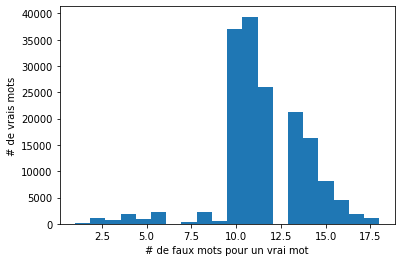

In [18]:
plt.hist(all_words_counter.values(), bins=20)
plt.ylabel("# de vrais mots")
plt.xlabel("# de faux mots pour un vrai mot")
plt.savefig("plots/candidates_histogram_before_balancing.png")

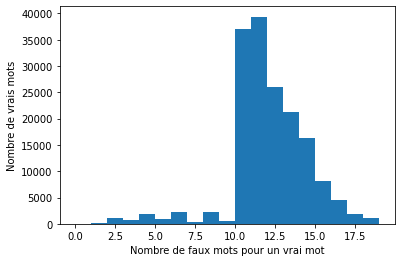

In [16]:
# same as before, on unfitered words
all_words_counter = Counter(word for word, _, _
                            in CandidatesPairCSV(Path("../workspaces/large_fr/candidates_filtering/steps/step_1_init.csv")))
plt.hist(all_words_counter.values(), bins=range(20))
plt.ylabel("Nombre de vrais mots")
plt.xlabel("Nombre de faux mots pour un vrai mot")
plt.savefig("plots/candidates_histogram.png")

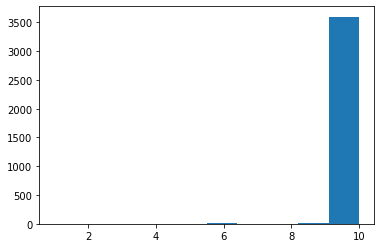

In [14]:
import csv
# Same as before, but for
with open("data/non-words.txt") as nonwords_csv:
    reader = csv.DictReader(nonwords_csv, delimiter="\t")
    gwendal_words_counter = Counter(
        row["Word"] for row in reader
    )
plt.hist(gwendal_words_counter.values())
plt.show()

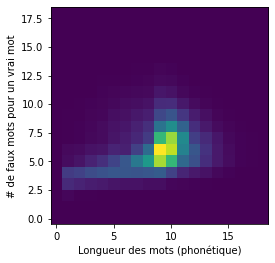

In [26]:
import numpy as np
all_words_counter = Counter(word_pho for _, word_pho, _
                            in candidates_csv)

word_lengths = [len(w.split(" ")) for w in all_words_counter]
heatmat = np.zeros((max(word_lengths) + 1, max(all_words_counter.values()) + 1))
for w_len, w_nb_fake_words in zip(word_lengths, all_words_counter.values()):
    heatmat[w_len, w_nb_fake_words] += 1

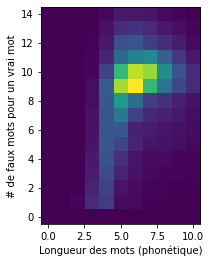

In [31]:
fake_heat_map = heatmat.copy()
fake_heat_map[1, 10] = 10000
plt.imshow(heatmat.transpose()[:15, :11], origin="lower")
plt.xlabel("Longueur des mots (phonétique)")
plt.ylabel("# de faux mots pour un vrai mot")
plt.savefig("plots/pho_len_vs_nb_candidates.png")